# Getting Started

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data and dataset modification

In [2]:
DATA_FOLDER = "../../data/"

PREPROCESSED_CHARACTER_DATASET = DATA_FOLDER+"preprocessed_character_metadata_2.tsv"
movies = pd.read_pickle(DATA_FOLDER+'movies.pkl')
character_metadata = pd.read_csv(PREPROCESSED_CHARACTER_DATASET, sep='\t')
character_metadata.columns = ['Wikipedia_movie_ID', 'Freebase_Movie_ID', 'Character_Name',
       'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release',
       'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID',
       'Freebase_Actor_ID', 'Movie_Release_Year', 'Ethnicity_Label']

We want to look at the character ethnicity representation depending on the country. Therefore, we can merge the character dataset with the column from the movie dataset containing the country of each film.  

In [3]:
character_countries = pd.merge(character_metadata,movies[['Wikipedia_movie_ID', 'FirstCountry_Name','SecondCountry_Name']], on = 'Wikipedia_movie_ID')
character_countries.sample(5)


,Wikipedia_movie_ID,Freebase_Movie_ID,Character_Name,Actor_Ethnicity,Actor_Name,Actor_Age_At_Movie_Release,Freebase_Character_Actor_Map_ID,Freebase_character_ID,Freebase_Actor_ID,Movie_Release_Year,Ethnicity_Label,FirstCountry_Name,SecondCountry_Name
10596,3616797,/m/09q5w2,Commodus,/m/041rx,Joaquin Phoenix,25.0,/m/0jytd4,/m/02nw89f,/m/018db8,2000.0,"['European', 'Jewish', 'Hungarian', 'European-...",United States of America,United Kingdom
11347,682393,/m/032l5l,Ronnie,/m/0x67,Jada Pinkett Smith,21.0,/m/0k0ltp,/m/0gxq_s2,/m/01j7z7,1993.0,"['Caribbean', 'Barbadian', 'Jamaican', 'North ...",United States of America,None
14734,3894895,/m/0b5ly7,Gruesome Gorilla,/m/041rx,Mel Blanc,39.0,/m/0hyn8d1,/m/0cww2c,/m/0c5vh,1948.0,"['European', 'Jewish', 'Asian', 'Russian', 'Ea...",United States of America,None
8061,10004330,/m/02pzjvb,Pigeon Lane,/m/0ffjvd,Jack Palance,30.0,/m/02vcl4m,/m/0h5cz0m,/m/02t_w8,1950.0,"['European', 'Eastern European', 'Ukrainian']",United States of America,None
10517,1028910,/m/03_njz,Barbara Novak,/m/06rd7,Renée Zellweger,34.0,/m/0jxhs1,/m/0gy9hxg,/m/01c_zw,2003.0,"['European', 'indigenous peoples', 'Asian', 'R...",United States of America,Germany


## Actor ethnicity in the US vs Rest of the world

We want to analyze the impact of 9/11 on the actor ethnicty within each film. In this purpose we will analyze the actor ethnicity changement befrore and after 9/11. Moreover, we expect for 9/11 to have a higher impact in the US compared to the rest of the world. Therefore, we will compare the data on those levels.

In [4]:
ethnicities_csv = pd.read_csv(DATA_FOLDER+"americans_by_descent.xls")
list_ethnicities = ethnicities_csv.columns[2:]

character = character_countries.copy()
print("length of the dataset: ", len(character))

#Separation into 2 datasets, one with only movies form the US and the other that contains all the other movies
# We use the first and second country associated with the film, if a film second or first country is US he will be in the US dataset otherwise he won't 

character_ROW = character.loc[~character["FirstCountry_Name"].str.contains('United States of America')]
print("length of the ROW dataset: ", len(character_ROW))

character_US = character.loc[character["FirstCountry_Name"].str.contains('United States of America')]
#Look at film which has as first country OR second country United states
additional_US = character_ROW.loc[character_ROW["SecondCountry_Name"].str.contains('United States of America', na=False)]
character_US = pd.concat([character_US, additional_US], ignore_index=True)
character_ROW = character_ROW.loc[~character_ROW.index.isin(additional_US.index)]

#reset the index

character_ROW = character_ROW.reset_index(drop = True)
character_US = character_US.reset_index(drop = True)

length of the dataset:  17033
length of the ROW dataset:  1058


We count the occurence of each ethnicity in both datasets

In [5]:
distribution_ROW = []
distribution_US = []

for eth in list_ethnicities:
    count = character_ROW['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_ROW.append(count)
    count = character_US['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_US.append(count)

In [6]:
ethnicities_dict = {
    'Ethnicity' : list_ethnicities,
    'Rest of the World' : distribution_ROW,
    'United States' : distribution_US
}

ethnicities_distribution = pd.DataFrame(ethnicities_dict)
ethnicities_distribution.head()

,Ethnicity,Rest of the World,United States
0,African,34,1052
1,Arab,23,498
2,Caribbean,43,809
3,European,722,12895
4,Greenlandic,0,0


In [7]:
ethnicity_top10_ROW = character_ROW['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_US = character_US['Ethnicity_Label'].value_counts().nlargest(10)

In [8]:
type(ethnicity_top10_ROW)

pandas.core.series.Series

In [9]:
sorted_ROW = ethnicities_distribution.sort_values(by='Rest of the World', ascending=False).head(10)
ethnicity_top10_ROW = sorted_ROW['Ethnicity'].head(10)
sorted_US = ethnicities_distribution.sort_values(by='United States', ascending=False).head(10)
ethnicity_top10_US = sorted_US['Ethnicity'].head(10)

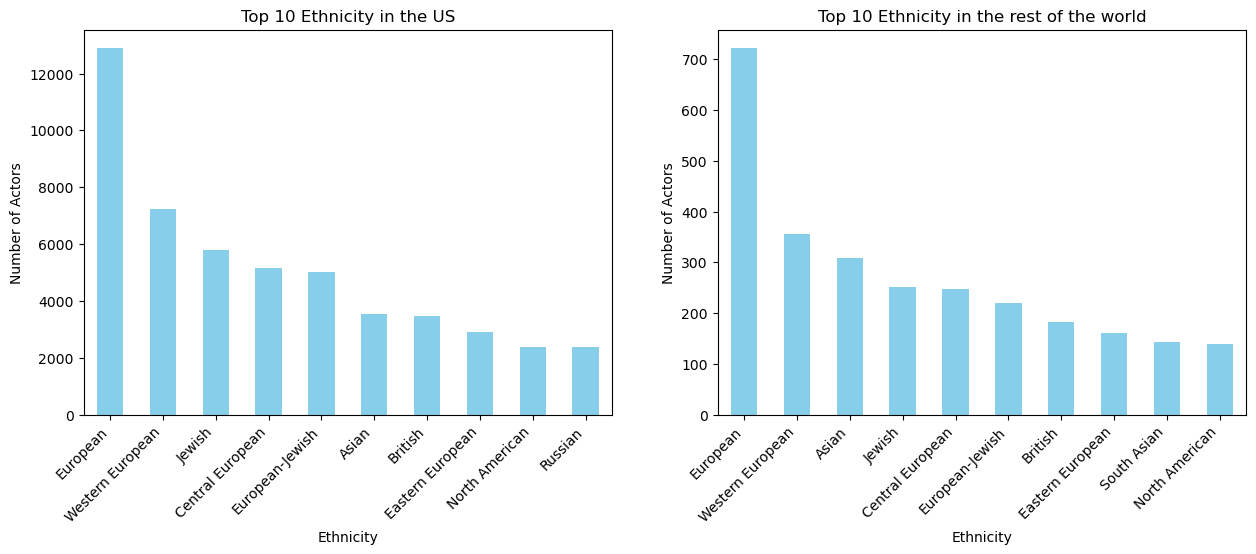

In [10]:
sorted_ROW = ethnicities_distribution.sort_values(by='Rest of the World', ascending=False).head(10)
sorted_US = ethnicities_distribution.sort_values(by='United States', ascending=False).head(10)

ethnicity_top10_ROW = sorted_ROW.set_index('Ethnicity')['Rest of the World']
ethnicity_top10_US = sorted_US.set_index('Ethnicity')['United States']

# Plot the distribution of each ethnicity
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
ethnicity_top10_US.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the US")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(1,2,2)
ethnicity_top10_ROW.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the rest of the world")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')
# plt.subplots_adjust(wspace=0.5)
plt.show()


We observe the top 10 ethnicty in the rest of the world differ from the top 10 ethnicty within the US. The African Americains is the most represented ethnicity in the US whereas in the rest of the world this is the indian. 

### The impact of 9/11

We will now deep into a reduce period of time, between 1993 and 2010 and observe the difference between ethnicities representation in the US compared to the rest of the world. 

In [11]:
# First for the US movies, we will filter the data for movies released between 1993 and 2001 and between 2002 and 2010,
# and study the most common ethnicities for these time periods.

#  Filter data for movies released between 1990 and 2001
data_1993_2001_US = character_US[(character_US['Movie_Release_Year'] >= 1993) & 
                                    (character_US['Movie_Release_Year'] <= 2001)]
data_2002_2010_US = character_US[(character_US['Movie_Release_Year'] >= 2002) & 
                                    (character_US['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
top_ethnicities_US = character_US['Ethnicity_Label'].value_counts().nlargest(10).index

# Filter for only these top ethnicities in each subset
data_1993_2001_top_US = data_1993_2001_US[data_1993_2001_US['Ethnicity_Label'].isin(top_ethnicities_US)]
data_2002_2010_top_US = data_2002_2010_US[data_2002_2010_US['Ethnicity_Label'].isin(top_ethnicities_US)]

# Count occurrences for each ethnicity in each time period
ethnicity_counts_1993_2001_US = data_1993_2001_top_US['Ethnicity_Label'].value_counts(normalize=True)
ethnicity_counts_2002_2010_US = data_2002_2010_top_US['Ethnicity_Label'].value_counts(normalize=True)

We apply the same procedure for the rest of the world

In [12]:
#  Filter data for movies released between 1990 and 2001
data_1993_2001_ROW = character_ROW[(character_ROW['Movie_Release_Year'] >= 1993) & 
                                    (character_ROW['Movie_Release_Year'] <= 2001)]
data_2002_2010_ROW = character_ROW[(character_ROW['Movie_Release_Year'] >= 2002) &
                                    (character_ROW['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
top_ethnicities_ROW = character_ROW['Ethnicity_Label'].value_counts().nlargest(10).index

# Filter for only these top ethnicities in each subset
data_1993_2001_top_ROW = data_1993_2001_ROW[data_1993_2001_ROW['Ethnicity_Label'].isin(top_ethnicities_ROW)]
data_2002_2010_top_ROW = data_2002_2010_ROW[data_2002_2010_ROW['Ethnicity_Label'].isin(top_ethnicities_ROW)]

# Count occurrences for each ethnicity in each time period
ethnicity_counts_1993_2001_ROW = data_1993_2001_top_ROW['Ethnicity_Label'].value_counts(normalize=True)
ethnicity_counts_2002_2010_ROW = data_2002_2010_top_ROW['Ethnicity_Label'].value_counts(normalize=True)

We can now plot the proportion of actor among the 10 most represented ethnicities, for the US and the rest of the world, and compare to see whether there is a different distribution in the two time periods.

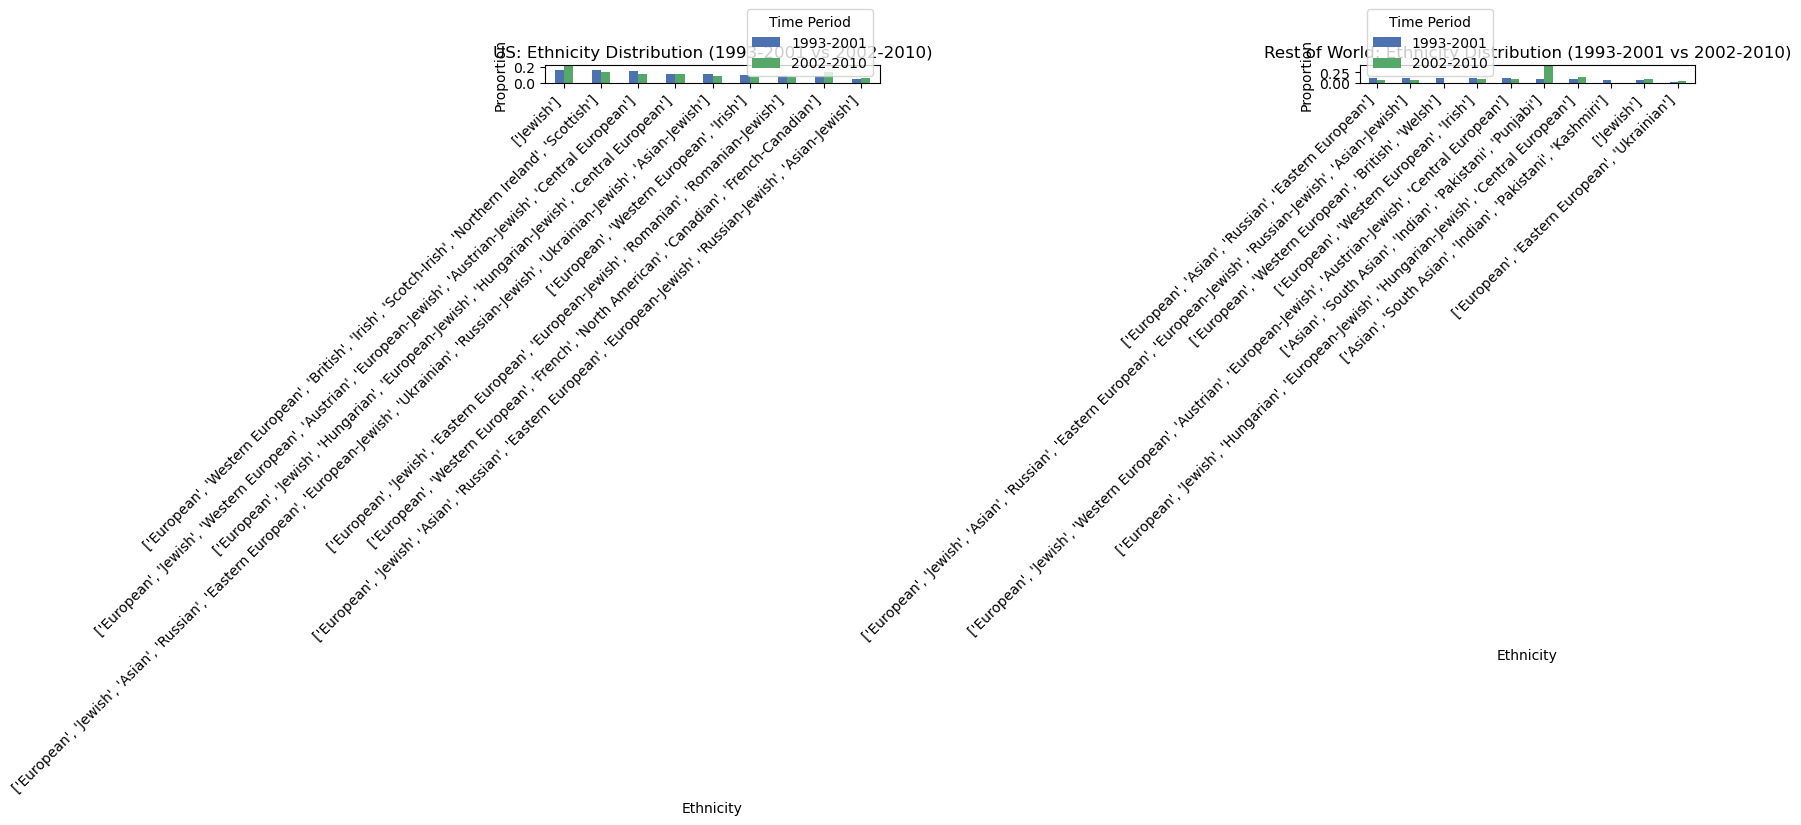

In [13]:

# Convert ethnicity counts to DataFrames for easier plotting
df_US = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1993_2001_US.index,
    '1993-2001': ethnicity_counts_1993_2001_US.values,
    '2002-2010': ethnicity_counts_2002_2010_US.reindex(ethnicity_counts_1993_2001_US.index, fill_value=0).values
})

df_ROW = pd.DataFrame({
    'Ethnicity': ethnicity_counts_1993_2001_ROW.index,
    '1993-2001': ethnicity_counts_1993_2001_ROW.values,
    '2002-2010': ethnicity_counts_2002_2010_ROW.reindex(ethnicity_counts_1993_2001_ROW.index, fill_value=0).values
})

# Set up the plotting style
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot for US
df_US.set_index('Ethnicity').plot(
    kind='bar', ax=axes[0], color=['#4c72b0', '#55a868']
)
axes[0].set_title('US: Ethnicity Distribution (1993-2001 vs 2002-2010)')
axes[0].set_ylabel('Proportion')
axes[0].set_xlabel('Ethnicity')
axes[0].legend(title="Time Period")
axes[0].set_xticklabels(df_US['Ethnicity'], rotation=45, ha="right")

# Plot for Rest of World
df_ROW.set_index('Ethnicity').plot(
    kind='bar', ax=axes[1], color=['#4c72b0', '#55a868']
)
axes[1].set_title('Rest of World: Ethnicity Distribution (1993-2001 vs 2002-2010)')
axes[1].set_ylabel('Proportion')
axes[1].set_xlabel('Ethnicity')
axes[1].legend(title="Time Period")
axes[1].set_xticklabels(df_ROW['Ethnicity'], rotation=45, ha="right")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


We observe there is no major changes in the top 10 actor ethnicities representation in the movies between 1993 and 2010 neither in the rest of the world or the United States.

Finally, we want to isolate the actor ethnicities that exhibit major changes before and after 9/11. Therefore, we will look at the top 10  actor ethnicites that exxhibit larger relative changes ratio. 

In [14]:
# Count the occurrences of each ethnicity in each period for rest of the world and US 
ethnicity_counts_1993_2001_US = data_1993_2001_US['Ethnicity_Label'].value_counts()
ethnicity_counts_2002_2010_US = data_2002_2010_US['Ethnicity_Label'].value_counts()

ethnicity_counts_1993_2001_ROW = data_1993_2001_ROW['Ethnicity_Label'].value_counts()
ethnicity_counts_2002_2010_ROW = data_2002_2010_ROW['Ethnicity_Label'].value_counts()

# We compute the relative changes for each ethnicites between 1991 and 2011
#Use absolute value to avoid the negative value and for subsequnet isolation of smaller and largest relative difference 
ratio_US = np.abs(ethnicity_counts_1993_2001_US - ethnicity_counts_2002_2010_US) / (ethnicity_counts_1993_2001_US)
ratio_ROW = np.abs(ethnicity_counts_1993_2001_ROW - ethnicity_counts_2002_2010_ROW) / (ethnicity_counts_1993_2001_ROW)


# Sort by the ratio to find the largest 
largest_ratios_US = ratio_US.nlargest(10)
largest_ratios_ROW = ratio_ROW.nlargest(10)

print("US: 5 Largest Ratios: \n \n", largest_ratios_US)
print("\n \n Rest of the world: 5 Largest Ratios:\n \n", largest_ratios_ROW)

US: 5 Largest Ratios: 
 
 Ethnicity_Label
['European', 'Jewish', 'Asian', 'Russian', 'Eastern European', 'European-Jewish', 'Ukrainian', 'Russian-Jewish', 'Ukrainian-Jewish', 'North American', 'Canadian', 'Asian-Jewish']    21.0
['European', 'Jewish', 'Western European', 'French']                                                                                                                                  16.0
['European', 'Western European', 'British', 'French']                                                                                                                                 13.0
['European', 'Scandinavian', 'Western European', 'British', 'Danish', 'German', 'South American', 'Argentine', 'Central European', 'English', 'Scottish']                              9.0
['Asian', 'South Asian', 'Indian', 'Gujarati']                                                                                                                                         8.0
['Caribbean', 'European

We observe ratios larger than 1 meaning they exhibit significant differences between the 2 observed periods, i.e before and after 9/11. From this first analysis, we do not observe any tendency of impact of 9/11 on racism. 

# World war 2

We now want to look at another event and there we will look at wolrd war 2. We want to analyze the impact of world war 2 on the actor ethnicty within each film. In this purpose we will analyze the actor ethnicity changement befrore and after world war 2. Moreover, we expect for wolrd war 2 to have a higher impact and earlier in the Europe compared to the US. Therefore, we will compare the data on those levels.

For world war 2 we are interested in the impact on European countries, US and Japan. Therefore, we look inot this 3 group of countries and compare with the rest of the world.

In [15]:
def map_continent(movie_country, continent_data_frame):
    label = continent_data_frame[continent_data_frame['Entity'] == movie_country]['World regions according to OWID']
    if len(label) > 0:
        return label.values[0]
    else:
        return None
continent_mapping_df = pd.read_csv(DATA_FOLDER+"continents.csv",sep=';')
continent_mapping_df.columns = ['Entity','World regions according to OWID']

In [16]:
from tqdm import tqdm

character.reset_index(drop=True, inplace=True)
for i in tqdm(range(len(character))):
    labels = map_continent(character['FirstCountry_Name'].iloc[i], continent_mapping_df)
    labels2 = map_continent(character['SecondCountry_Name'].iloc[i], continent_mapping_df)
    character.at[i, 'Continent'] = labels
    character.at[i,'Second_Continent'] = labels2


100%|██████████| 17033/17033 [00:02<00:00, 6714.04it/s]


In [17]:
character.columns

Index(['Wikipedia_movie_ID', 'Freebase_Movie_ID', 'Character_Name',
       'Actor_Ethnicity', 'Actor_Name', 'Actor_Age_At_Movie_Release',
       'Freebase_Character_Actor_Map_ID', 'Freebase_character_ID',
       'Freebase_Actor_ID', 'Movie_Release_Year', 'Ethnicity_Label',
       'FirstCountry_Name', 'SecondCountry_Name', 'Continent',
       'Second_Continent'],
      dtype='object')

In [18]:
ethnicities_csv = pd.read_csv(DATA_FOLDER+"americans_by_descent.xls")
list_ethnicities = ethnicities_csv.columns[2:]

print("length of the dataset: ", len(character))

#Separation into 5 datasets, one for North America, one for South America, one Europe, one Asia and one for Africa
#We chose to separate into 4 datasets in order to have enough data
#Count as many times as necessary an actor if he turned film in different continent
character_EU = character.loc[(character['Continent']=='Europe') | (character['Second_Continent']== 'Europe')]
character_NA = character.loc[(character['Continent']=='North America') | (character['Second_Continent']=='North America')]
character_AS = character.loc[(character['Continent']=='Asia') | (character['Second_Continent']=='Asia')]
character_SA = character.loc[(character['Continent']=='South America') | (character['Second_Continent']=='South America')]
character_AF = character.loc[(character['Continent']=='Africa') | (character['Second_Continent']=='Africa')]

#reset the index
character_EU = character_EU.reset_index(drop = True)
character_NA = character_NA.reset_index(drop = True)
character_AS = character_AS.reset_index(drop = True)
character_SA = character_SA.reset_index(drop = True)
character_AF = character_AF.reset_index(drop = True)


length of the dataset:  17033


We count the occurence for each ethnicities in eah of the four dataset:

In [20]:
distribution_NA = []
distribution_AS = []
distribution_SA = []
distribution_AF = []
distribution_EU = []

for eth in list_ethnicities:
    count = character_NA['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_NA.append(count)
    count = character_AS['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_AS.append(count)
    count = character_SA['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_SA.append(count)
    count = character_AF['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_AF.append(count)
    count = character_EU['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_EU.append(count)

In [21]:
ethnicities_dict = {
    'Ethnicity' : list_ethnicities,
    'North America' : distribution_NA,
    'South America' : distribution_SA,
    'Africa' : distribution_AF,
    'Asia' : distribution_AS,
    'Europe' : distribution_EU
}

ethnicities_distribution = pd.DataFrame(ethnicities_dict)
ethnicities_distribution.head()

,Ethnicity,North America,South America,Africa,Asia,Europe
0,African,1057,1,4,11,120
1,Arab,503,0,1,5,49
2,Caribbean,818,0,1,13,80
3,European,13052,18,26,166,1527
4,Greenlandic,0,0,0,0,0


In [22]:
ethnicity_top10_NA = character_NA['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_AS = character_AS['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_SA = character_SA['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_EU = character_EU['Ethnicity_Label'].value_counts().nlargest(10)
ethnicity_top10_AF = character_AF['Ethnicity_Label'].value_counts().nlargest(10)


In [23]:
sorted_NA = ethnicities_distribution.sort_values(by='North America', ascending=False).head(10)
ethnicity_top10_NA = sorted_NA['Ethnicity'].head(10)
sorted_SA = ethnicities_distribution.sort_values(by='South America', ascending=False).head(10)
ethnicity_top10_SA = sorted_SA['Ethnicity'].head(10)
sorted_AS = ethnicities_distribution.sort_values(by='Asia', ascending=False).head(10)
ethnicity_top10_AS = sorted_AS['Ethnicity'].head(10)
sorted_AF = ethnicities_distribution.sort_values(by='Africa', ascending=False).head(10)
ethnicity_top10_AF = sorted_AF['Ethnicity'].head(10)
sorted_EU = ethnicities_distribution.sort_values(by='Europe', ascending=False).head(10)
ethnicity_top10_EU = sorted_EU['Ethnicity'].head(10)

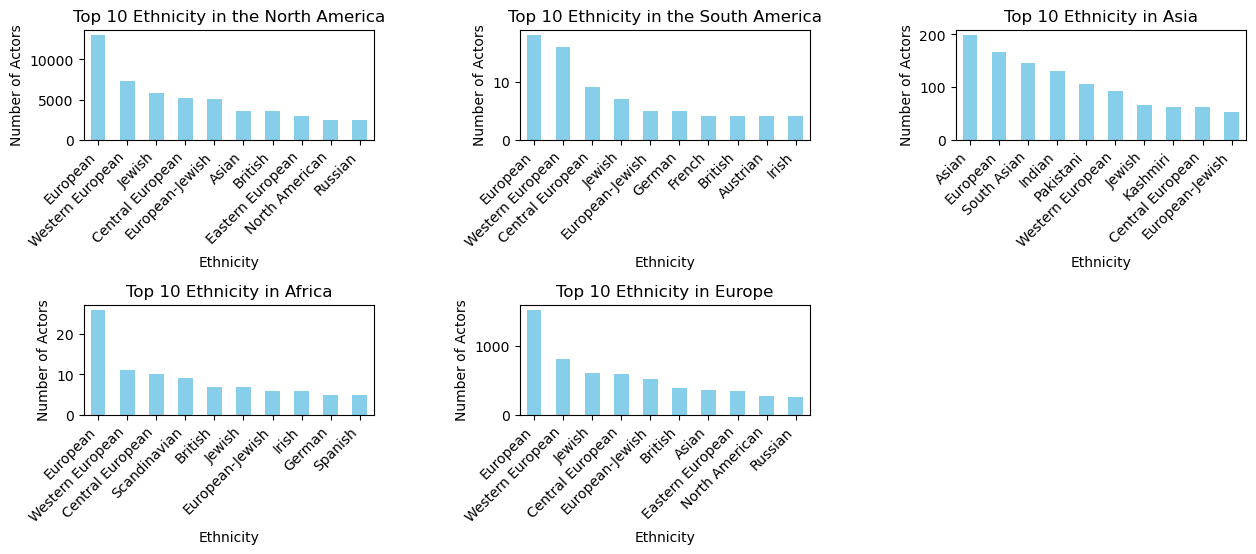

In [24]:
ethnicity_top10_NA = sorted_NA.set_index('Ethnicity')['North America']
ethnicity_top10_SA = sorted_SA.set_index('Ethnicity')['South America']
ethnicity_top10_AF = sorted_AF.set_index('Ethnicity')['Africa']
ethnicity_top10_AS = sorted_AS.set_index('Ethnicity')['Asia']
ethnicity_top10_EU = sorted_EU.set_index('Ethnicity')['Europe']

# Plot the distribution of each ethnicity
plt.figure(figsize=(15,5))
plt.subplot(2,3,1)
ethnicity_top10_NA.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the North America")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(2,3,2)
ethnicity_top10_SA.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in the South America")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')
plt.subplots_adjust(wspace=0.5,hspace=1.5)

plt.subplot(2,3,3)
ethnicity_top10_AS.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in Asia")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(2,3,4)
ethnicity_top10_AF.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in Africa")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')

plt.subplot(2,3,5)
ethnicity_top10_EU.plot(kind='bar', color='skyblue')
plt.title("Top 10 Ethnicity in Europe")
plt.xlabel("Ethnicity")
plt.ylabel("Number of Actors")
plt.xticks(rotation=45, ha='right')
plt.show()

est-ce que on split avec les countries if only Japan? Meme quand on regarde dnas only Japan, rarement Japanese plutot european. 

We want to ensure the presence of so many european in the results are not due to the numerous countries of the film, therefore we look at movies which have only Japan as movie country. 

In [25]:
character_only_AS = character_AS[character_AS['Continent']=='Asia']
distribution_only_AS = []
for eth in list_ethnicities:
    count = character_only_AS['Ethnicity_Label'].apply(lambda x: 1 if eth in x else 0).sum()
    distribution_only_AS.append(count)
ethnicities_dict_AS = {
    'Ethnicity' : list_ethnicities,
    'Asia' : distribution_only_AS
}

ethnicities_distribution_AS = pd.DataFrame(ethnicities_dict_AS)
sorted_only_AS = ethnicities_distribution.sort_values(by='Asia', ascending=False).head(10)
print(len(ethnicities_distribution_AS))
ethnicity_top10_only_AS = sorted_only_AS['Ethnicity'].head(10)

ethnicity_top10_only_AS.head(10)

491


69                Asian
3              European
70          South Asian
370              Indian
373           Pakistani
103    Western European
6                Jewish
476            Kashmiri
403    Central European
145     European-Jewish
Name: Ethnicity, dtype: object

We observe the top 5 include European, therefore meaning this observed effect is not caused by the presence of multiple countries. 

## Impact of World War 2

We will now deep into a reduce period of time, between 1930 and 1950 and observe the difference between ethnicities representation in the US compared to the rest of the world.

In [ ]:
# First for the North America movies, we will filter the data for movies released between 1993 and 2001 and between 2002 and 2010,
# and study the most common ethnicities for these time periods.

#  Filter data for based on release year
data_1993_2001_US = character_US[(character_US['Movie_Release_Year'] >= 1993) & 
                                    (character_US['Movie_Release_Year'] <= 2001)]
data_2002_2010_US = character_US[(character_US['Movie_Release_Year'] >= 2002) & 
                                    (character_US['Movie_Release_Year'] <= 2010)]
data_1993_2010_US = character_US[(character_US['Movie_Release_Year'] >= 1993) &
                                    (character_US['Movie_Release_Year'] <= 2010)]

# Count the top 10 ethnicities overall
ethnicities_distribution_US, top_ethnicities_US = extract_top_10(data_1993_2010_US)

# Extract the ethnicity distribution for each time period
distribution_1993_2001_US, _ = extract_top_10(data_1993_2001_US)
distribution_2002_2010_US, _ = extract_top_10(data_2002_2010_US)

# Occurrences for the top 10 ethnicities in each time period
ethnicity_counts_1993_2001_US = distribution_1993_2001_US[distribution_1993_2001_US['Ethnicity'].isin(top_ethnicities_US)]
ethnicity_counts_2002_2010_US = distribution_2002_2010_US[distribution_2002_2010_US['Ethnicity'].isin(top_ethnicities_US)]
